In [73]:
import os,math,random, gc,datetime
import platform
import logging
logging.getLogger().setLevel(logging.CRITICAL)

#package imports
import numpy as np
import pandas as pd
from tqdm import tqdm

#plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#local imports
from utils.helpers import find_play_type

#Stats imports
import statsmodels as sm
from scipy import stats

#File paths below
#check kaggle or local
if platform.platform() == 'Linux-5.15.133+-x86_64-with-glibc2.31':
    FILE_PATH = '/kaggle/input/nfl-big-data-bowl-2024'
else:
    FILE_PATH = './nfl-big-data-bowl-2024'
GAMES_PATH = os.path.join(FILE_PATH,'games.csv')
PLAYS_PATH = os.path.join(FILE_PATH,'plays.csv')
PLAYERS_PATH = os.path.join(FILE_PATH,'players.csv')
TACKLES_PATH = os.path.join(FILE_PATH,'tackles.csv')

#Tracking weeks
WEEK1_PATH = os.path.join(FILE_PATH,'tracking_week_1.csv')
WEEK2_PATH = os.path.join(FILE_PATH,'tracking_week_2.csv')
WEEK3_PATH = os.path.join(FILE_PATH,'tracking_week_3.csv')
WEEK4_PATH = os.path.join(FILE_PATH,'tracking_week_4.csv')
WEEK5_PATH = os.path.join(FILE_PATH,'tracking_week_5.csv')
WEEK6_PATH = os.path.join(FILE_PATH,'tracking_week_6.csv')
WEEK7_PATH = os.path.join(FILE_PATH,'tracking_week_7.csv')
WEEK8_PATH = os.path.join(FILE_PATH,'tracking_week_8.csv')
WEEK9_PATH = os.path.join(FILE_PATH,'tracking_week_9.csv')



## Load Data

In [74]:
games_df = pd.read_csv(GAMES_PATH)
players_df = pd.read_csv(PLAYERS_PATH)
plays_df = pd.read_csv(PLAYS_PATH)
tackles_df = pd.read_csv(TACKLES_PATH)

#tracking week 1
week1_df = pd.read_csv(WEEK1_PATH)
week2_df = pd.read_csv(WEEK2_PATH)
week3_df = pd.read_csv(WEEK3_PATH)
week4_df = pd.read_csv(WEEK4_PATH)
week5_df = pd.read_csv(WEEK5_PATH)
week6_df = pd.read_csv(WEEK6_PATH)
week7_df = pd.read_csv(WEEK7_PATH)
week8_df = pd.read_csv(WEEK8_PATH)
week9_df = pd.read_csv(WEEK9_PATH)

#concat all weeks
all_weeks = pd.concat([week1_df,week2_df,week3_df,week4_df,week5_df,week6_df,week7_df,week8_df,week9_df])

### Breakdown to individual events

In [75]:
#individual events
pass_occurs = all_weeks[all_weeks['event']=='pass_forward']
pass_arrives = all_weeks[all_weeks['event']=='pass_arrived']
tackle_occurs = all_weeks[all_weeks['event']=='tackle']

#label the tackler
tackle_occurs['tackler'] = False

for i,r in tackles_df.iterrows():
    play = tackle_occurs[(tackle_occurs['gameId']==r['gameId']) & (tackle_occurs['playId']==r['playId'])]
    tackle_occurs.loc[play.index,'tackler'] = pd.Series(np.where((play['nflId']==r['nflId']),True,False), index=play.index)

pass_arrives['tackler'] = False

for i,r in tackles_df.iterrows():
    play = pass_arrives[(pass_arrives['gameId']==r['gameId']) & (pass_arrives['playId']==r['playId'])]
    pass_arrives.loc[play.index,'tackler'] = pd.Series(np.where((play['nflId']==r['nflId']),True,False), index=play.index)

pass_occurs['tackler'] = False

for i,r in tackles_df.iterrows():
    play = pass_occurs[(pass_occurs['gameId']==r['gameId']) & (pass_occurs['playId']==r['playId'])]
    pass_occurs.loc[play.index,'tackler'] = pd.Series(np.where((play['nflId']==r['nflId']),True,False), index=play.index)
    


C:\Users\batuu\AppData\Local\Temp\ipykernel_41316\2672042446.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tackle_occurs['tackler'] = False
C:\Users\batuu\AppData\Local\Temp\ipykernel_41316\2672042446.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_arrives['tackler'] = False
C:\Users\batuu\AppData\Local\Temp\ipykernel_41316\2672042446.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

## Individual event distribution

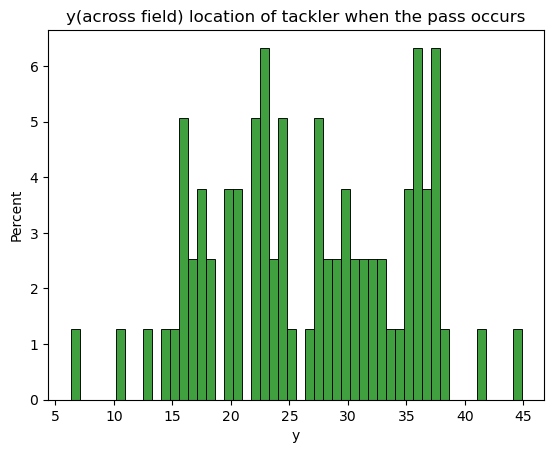

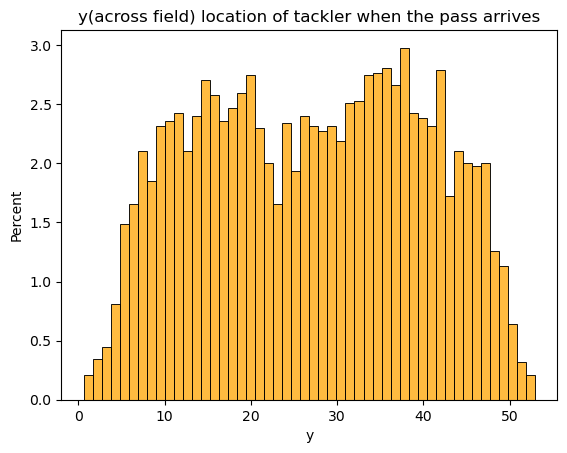

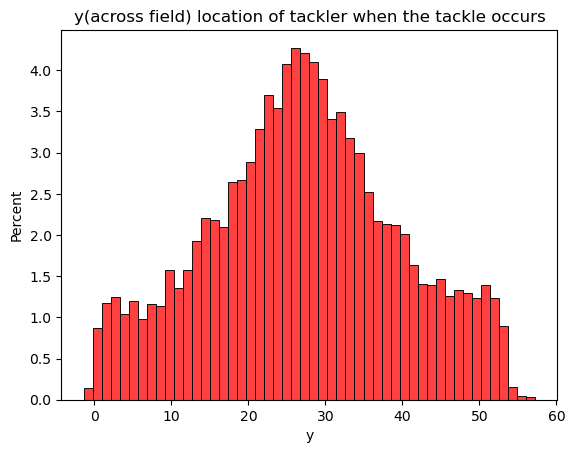

In [76]:
stat = 'y(across field) location'
col = 'y'

plt.title(f'{stat} of tackler when the pass occurs')
sns.histplot(x=col,data=pass_occurs[pass_occurs['tackler']==True],stat='percent',bins=50,color='green')
plt.show()
plt.cla()


plt.title(f'{stat} of tackler when the pass arrives')
sns.histplot(x=col,data=pass_arrives[pass_arrives['tackler']==True],stat='percent',bins=50,color='orange')
plt.show()
plt.cla()

plt.title(f'{stat} of tackler when the tackle occurs')
sns.histplot(x=col,data=tackle_occurs[tackle_occurs['tackler']==True],stat='percent',bins=50, color='red')
plt.show()
#tackle_occurs[tackle_occurs['tackler']==True]['y'].hist(bins=50)

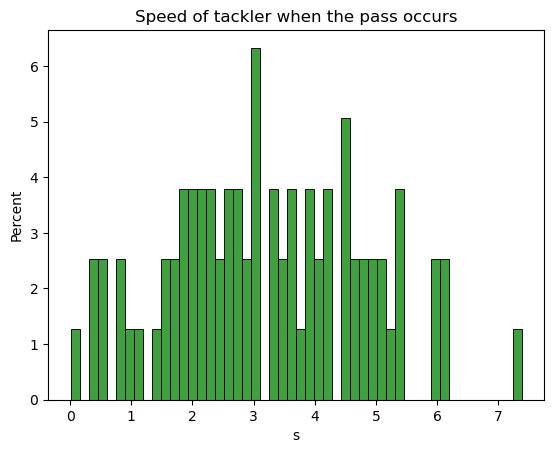

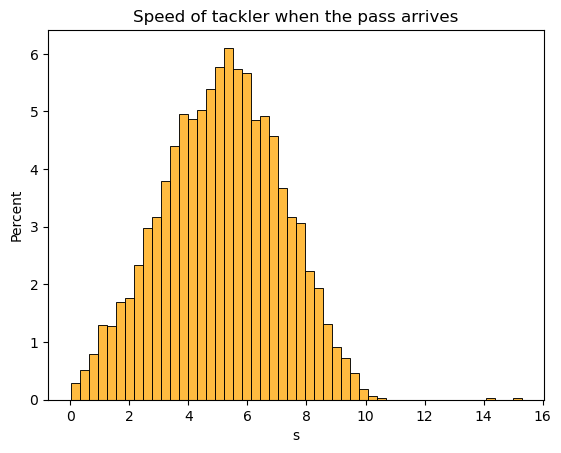

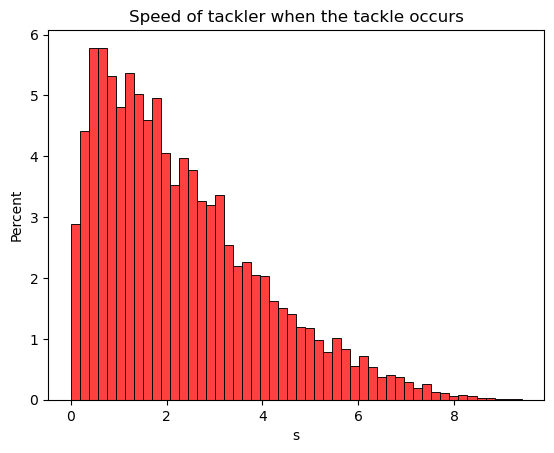

In [77]:
stat = 'Speed'
col = 's'

plt.title(f'{stat} of tackler when the pass occurs')
sns.histplot(x=col,data=pass_occurs[pass_occurs['tackler']==True],stat='percent',bins=50,color='green')
plt.show()
plt.cla()


plt.title(f'{stat} of tackler when the pass arrives')
sns.histplot(x=col,data=pass_arrives[pass_arrives['tackler']==True],stat='percent',bins=50,color='orange')
plt.show()
plt.cla()

plt.title(f'{stat} of tackler when the tackle occurs')
sns.histplot(x=col,data=tackle_occurs[tackle_occurs['tackler']==True],stat='percent',bins=50, color='red')
plt.show()

In [78]:
pass_arrives2 = pass_arrives.copy()

pass_arrives2['result'] = 0
for i,r in pass_arrives2.iterrows():
    pass_arrives2.loc[i,'result'] = plays_df[(plays_df['playId']==r['playId']) & (plays_df['gameId']==r['gameId'])]['playResult'].values[0]

Correlation between tackler acceleration and play yards on catch: 0.1657
Significant p-value: 2.76e-30


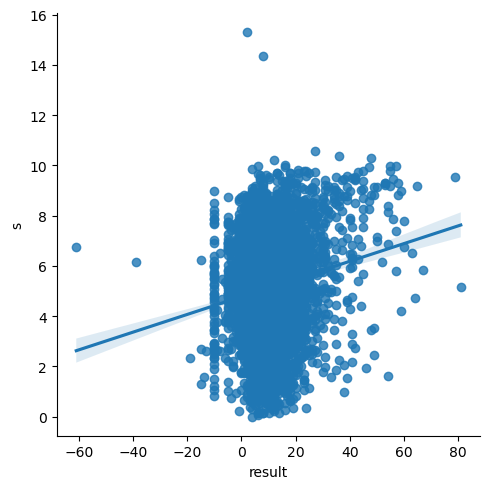

In [79]:
pa_tackle = pass_arrives2[pass_arrives2['tackler']==True]

r,p = stats.pearsonr(pa_tackle['result'],pa_tackle['s'])

print(f'Correlation between tackler acceleration and play yards on catch: {r:.4f}')
if p < 0.05:
    print('Significant',f'p-value: {p:.2e}')
sns.lmplot(x='result',y='s',data=pa_tackle)